## LSTM测试

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import date
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
import numpy as np
import requests
from requests.auth import HTTPBasicAuth
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import joblib
import random
import os
import tensorflow as tf

/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [26]:
today = pd.to_datetime("today").normalize()

In [3]:
data = yf.download("CNYGBP=X", start="2015-01-01", end=today)
all_test_df = data
all_test_df['ER'] = (all_test_df['High'] + all_test_df['Low']) / 2
all_test_df['inverse'] = 1/all_test_df['ER']
er_df = all_test_df[['inverse']].rename(columns={"Close": "CNY/GBP"})

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


In [29]:
today + timedelta(days=1)

Timestamp('2025-06-05 00:00:00')

In [4]:
er_df.tail()

Price,inverse
Ticker,
Date,
2025-05-28,9.716332
2025-05-29,9.699744
2025-05-30,9.712132
2025-06-02,9.703745
2025-06-03,9.703745


In [5]:
policy_df = pd.read_excel("test_files/IR.xlsx")
policy_df['rate_diff'] = policy_df['UK'] - policy_df['CN']
model_df = policy_df.copy()

# 确保 Date 是 datetime 类型
model_df['Date'] = pd.to_datetime(model_df['Date'])

# 保留工作日（周一到周五）
df_weekday = model_df[model_df['Date'].dt.dayofweek < 5].copy()

# 按日期排序（可选）
df_weekday = df_weekday.sort_values('Date').reset_index(drop=True)

# 确保 Date 列格式一致
df_weekday['Date'] = pd.to_datetime(df_weekday['Date']).dt.normalize()

# 筛选 df_weekday 中仅保留那些出现在 er_df['Date'] 中的行
df_weekday_aligned = df_weekday[df_weekday['Date'].isin(er_df.index)].copy()

df_weekday_aligned = df_weekday_aligned.reset_index(drop=True)
df_weekday_aligned.drop(['UK','CN'], axis=1, inplace=True)
er_mid = er_df['inverse'].reset_index(drop=True)
er_mid

0       9.621861
1       9.563429
2       9.499834
3       9.454924
4       9.389671
          ...   
2709    9.716332
2710    9.699744
2711    9.712132
2712    9.703745
2713    9.703745
Name: inverse, Length: 2714, dtype: float64

In [6]:
while len(df_weekday_aligned) < len(er_mid):
    last_date = df_weekday_aligned['Date'].iloc[-1]
    # 获取下一个工作日（跳过周末）
    next_workday = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=1, freq='B')[0]

    new_row = {col: np.nan for col in df_weekday_aligned.columns}
    new_row['Date'] = next_workday
    new_row['rate_diff'] = 1.15

    df_weekday_aligned = pd.concat([df_weekday_aligned, pd.DataFrame([new_row])], ignore_index=True)
df_weekday_aligned['ER'] = er_mid

In [7]:
df_weekday_aligned['trade_war'] = 0
df_weekday_aligned.loc[(df_weekday_aligned['Date'] >= '2018-03-22') & (df_weekday_aligned['Date'] <= '2018-12-01'), 'trade_war'] = 1
df_weekday_aligned.loc[(df_weekday_aligned['Date'] >= '2025-02-01') , 'trade_war'] = 1

In [8]:
df_all = df_weekday_aligned
df_all['Date'] = pd.to_datetime(df_all['Date'])

In [9]:
df_all['prev_change'] = df_all['ER'].pct_change().fillna(0)

# Create trend direction label (1 if next day up, 0 if down)
df_all['trend_up'] = (df_all['ER'].diff().shift(-1) > 0).astype(int)
#df_all['volatility_5'] = df_all['ER'].pct_change().rolling(window=5).std()

df_all.dropna(inplace=True)  # drop last row if trend_up for next day is NaN

# Display the final feature set
display(df_all.tail(5))

,Date,rate_diff,ER,trade_war,prev_change,trend_up
2709,2025-05-28,1.15,9.716332,1,-0.004299,0
2710,2025-05-29,1.15,9.699744,1,-0.001707,1
2711,2025-05-30,1.15,9.712132,1,0.001277,0
2712,2025-06-02,1.15,9.703745,1,-0.000864,0
2713,2025-06-03,1.15,9.703745,1,0.000000,0


In [10]:
lstm_df = df_all.drop(['prev_change'], axis=1)

lstm_df['Date'] = pd.to_datetime(lstm_df['Date'])  # 保证为 datetime 类型
lstm_df = lstm_df.set_index('Date')  # 设置为 index

In [11]:
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 固定 TensorFlow 随机种子
tf.random.set_seed(42)

# 若用GPU，确保 TensorFlow 使用确定性算法
# 注意：这会牺牲一定速度
from tensorflow.keras import backend as K
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [12]:
lstm_df['Date'] = lstm_df.index
today = pd.to_datetime("today")
cutoff = pd.to_datetime("2025-05-26")

In [13]:
lstm_df['Date'] = pd.to_datetime(lstm_df['Date'])
if today > cutoff + timedelta(days=30):
    print("超过30天，重新训练模型...")
    lstm_df_model = lstm_df[lstm_df['Date'] < today]

    lstm_df_model = lstm_df_model.drop(columns=['Date'], axis=1)
    cutoff = today
else:
    lstm_df_model = lstm_df[lstm_df['Date'] < cutoff]
    lstm_df_model = lstm_df_model.drop(['Date'], axis=1)
lstm_df = lstm_df.drop(['Date'], axis=1)
lstm_df_model.tail()

,rate_diff,ER,trade_war,trend_up
Date,,,,
2025-05-19,1.15,9.622694,1,1
2025-05-20,1.15,9.636232,1,1
2025-05-21,1.15,9.695136,1,0
2025-05-22,1.15,9.663750,1,1
2025-05-23,1.15,9.708879,1,1


In [14]:
# Split data into training and testing sets using 80/20 ratio
split_idx = int(len(lstm_df_model) * 0.91)
train_df = lstm_df_model.iloc[:split_idx]
test_df = lstm_df_model.iloc[split_idx:]

# Separate features (X) and target (y)
X_train = train_df.drop(['rate_diff'],axis=1) # 注意：这里只取特征列
y_train = train_df['ER']
X_test = test_df.drop(['rate_diff'],axis=1)
y_test = test_df['ER']

# Normalize features and target using Min-Max scaling (fit on training data only)
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Prepare data for LSTM: create sequences of length `lookback` for each training example
lookback = 12  # use past 12 months to predict the next month
X_train_seq, y_train_seq = [], []
for i in range(lookback, len(X_train_scaled)):
    # sequence of `lookback` feature vectors
    X_train_seq.append(X_train_scaled[i-lookback:i])
    # target is the exchange rate at this time (one month ahead of last input month)
    y_train_seq.append(y_train_scaled[i])
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)

# Prepare sequences for the test set (using preceding data for initial sequence)
X_test_seq, y_test_seq = [], []
# Concatenate train and test for sequence generation to include trailing train data in initial test sequences
total_X = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
total_y = np.concatenate((y_train_scaled, y_test_scaled), axis=0)
train_len = len(X_train_scaled)
for i in range(train_len, len(total_X)):
    if i < lookback:
        continue  # skip until we have enough history
    X_test_seq.append(total_X[i-lookback:i])
    y_test_seq.append(total_y[i])
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# Build the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# 改进后的双层 LSTM 架构
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(lookback, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1))

# 别忘了这一步！！
model.compile(optimizer='adam', loss='mean_squared_error')

# 然后再训练
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

#model.save("baseline_model_85.h5")

Epoch 1/50


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-06-04 14:54:01.364499: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{nod

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0367 - val_loss: 4.6374e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 7.8233e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 7.6790e-04
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 5.0232e-04
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 4.6534e-04
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 6.5945e-04
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 9/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4095e-04 - val_loss: 6.8781e-04
Epoch 10/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 5.2865e-04
Epoch 11/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7548e-04 - val_loss: 0.0010
Epoch 12/50
138/138 ━━━

Test MSE Loss: 0.000229
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2025-06-04 14:54:19.484967: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 14:54:19.485212: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

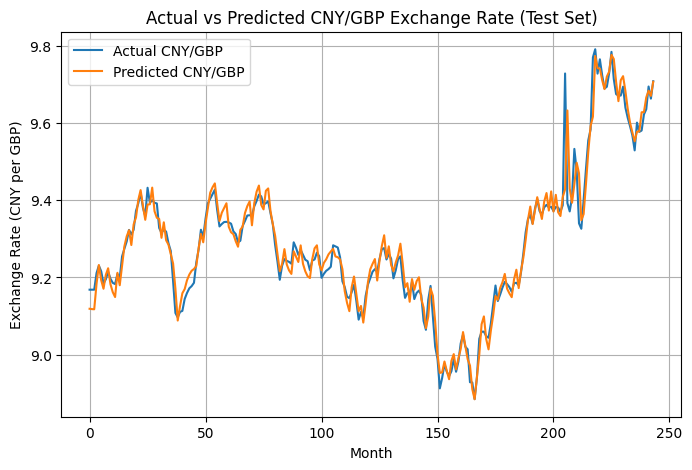

In [15]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test MSE Loss: {test_loss:.6f}")

# Make predictions for the test period
y_pred_scaled = model.predict(X_test_seq)
# Inverse-transform the predictions back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_actual = target_scaler.inverse_transform(y_test_seq)

# Visualize the results: Actual vs Predicted exchange rate

plt.figure(figsize=(8,5))
plt.plot(y_actual, label='Actual CNY/GBP')
plt.plot(y_pred, label='Predicted CNY/GBP')
plt.title('Actual vs Predicted CNY/GBP Exchange Rate (Test Set)')
plt.xlabel('Month')
plt.ylabel('Exchange Rate (CNY per GBP)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
pred_df = pd.DataFrame(y_pred)
y_test = y_test.iloc[:-1]
error_cal = pd.DataFrame({})
error_cal['pred'] = pred_df
y_mid = y_test.reset_index(drop=True)
error_cal['actual'] = y_mid
error_cal['error'] = error_cal['pred'] - error_cal['actual']

In [17]:
#error_cal = error_cal[-15:]

In [18]:
#error_cal = error_cal.head(10)

In [19]:
error_cal

,pred,actual,error
0,9.118895,9.168382,-0.049487
1,9.118059,9.168382,-0.050323
2,9.117560,9.168382,-0.050822
3,9.183608,9.211538,-0.027930
4,9.232285,9.230755,0.001529
...,...,...,...
239,9.628819,9.622694,0.006124
240,9.666919,9.636232,0.030687
241,9.684306,9.695136,-0.010830
242,9.670940,9.663750,0.007190


In [20]:
# 计算实际值和预测值的变化趋势（相邻天数差）
actual_diff = error_cal['actual'].diff()
pred_diff = error_cal['pred'].diff()

# 判断趋势是否一致（同为正或同为负 → 相乘大于0）
trend_correct = (actual_diff * pred_diff) > 0

# 去除第一个 NaN（因为 diff 会在第一行生成 NaN）
trend_correct = trend_correct[1:-1]

# 计算正确比例
trend_accuracy = trend_correct.sum() / len(trend_correct)

# 输出
print(f"趋势判断正确的比例为: {trend_accuracy:.2%}")

threshold = 0.05
proportion = (error_cal['error'].abs() > threshold).mean()

print(f"误差小于 0.05 的比例为：{(1-proportion):.2%}")

趋势判断正确的比例为: 96.69%
误差小于 0.05 的比例为：95.08%


In [21]:
actual_cleaned = actual_diff.dropna()
pred_mid = pred_diff.dropna()
pred_cleaned = pred_mid.iloc[:-1]

# 假设涨跌的分类标准是：大于等于0 为 'Up'，否则为 'Down'
actual_labels = ['Up' if x >= 0 else 'Down' for x in actual_cleaned]
pred_labels = ['Up' if x >= 0 else 'Down' for x in pred_cleaned]


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(actual_labels, pred_labels))
print(classification_report(actual_labels, pred_labels, target_names=['Down', 'Up']))


[[108   4]
 [  4 126]]
              precision    recall  f1-score   support

        Down       0.96      0.96      0.96       112
          Up       0.97      0.97      0.97       130

    accuracy                           0.97       242
   macro avg       0.97      0.97      0.97       242
weighted avg       0.97      0.97      0.97       242



## 使用全部数据进行训练，预测未来汇率

In [23]:
X_train_all = lstm_df.drop(['rate_diff'],axis=1)
y_train_all = lstm_df['ER']
target_scaler = MinMaxScaler()
# Normalize features and target using Min-Max scaling (fit on training data only)
feature_scaler = MinMaxScaler()
X_train_scaled_all = feature_scaler.fit_transform(X_train_all)
y_train_scaled_all = target_scaler.fit_transform(y_train_all.values.reshape(-1, 1))

# Prepare data for LSTM: create sequences of length `lookback` for each training example
lookback = 12  # use past 12 months to predict the next month

In [24]:
# 1. 准备输入
X_latest = X_train_scaled_all[-lookback:]
X_latest = X_latest.reshape(1, lookback, X_latest.shape[1])

# 2. 预测
y_pred_scaled = model.predict(X_latest)

# 3. 反归一化
y_pred = target_scaler.inverse_transform(y_pred_scaled)
print(f"Predicted next exchange rate: {y_pred[0][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted next exchange rate: 9.6774


In [42]:
pred_date = df_all['Date'].iloc[-1] + timedelta(days=1)
output = pd.DataFrame({
    'date': pred_date,
    'predicted_rate': [round(y_pred[0][0], 4)]
})

In [43]:
output.to_csv('result.csv', index=False)